In [13]:
import torch
from algo_reasoning.src.sampler import CLRSDataset

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Pretrained Model

In [15]:
from algo_reasoning.src.models.network import EncodeProcessDecode
from algo_reasoning.src.lightning.AlgorithmicReasoningTask import AlgorithmicReasoningTask 
from algo_reasoning.src.specs import CLRS_30_ALGS
from algo_reasoning.src.losses.AlgorithmicReasoningLoss import AlgorithmicReasoningLoss

In [16]:
ckpt_path = "../checkpoints/Generalist/Generalist-epoch=49-val_loss=0.76.ckpt"

model = EncodeProcessDecode(CLRS_30_ALGS)
loss_fn = AlgorithmicReasoningLoss()

model = AlgorithmicReasoningTask.load_from_checkpoint(ckpt_path, model=model, loss_fn=loss_fn).model

# Graph Fourier Analysis of Algorithmic Embeddings

## Toy Example: Graph Fourier Transform of BFS Embeddings

In [17]:

def fourier_transform(embeddings, nb_nodes):
    """
    Compute the Fourier Transform of the embeddings.

    Args:
        embeddings: a tensor of shape (batch_size, sequence_length, embedding_dim)

    Returns:
        a tensor of shape (batch_size, sequence_length, embedding_dim)
    """

    laplacian = torch.diag(torch.ones(nb_nodes, device=device)*nb_nodes) - torch.ones((nb_nodes, nb_nodes), device=device)
    result = torch.linalg.eigh(laplacian)
    eigenvalues = result.eigenvalues
    eigenvectors = result.eigenvectors
    
    eigenvalues[torch.isclose(eigenvalues, torch.tensor(0.))] = 0.

    return eigenvectors.T@embeddings, eigenvectors, eigenvalues

In [ ]:
# Load dataset
algorithm_args = {
    'p': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}

algorithms = ["dfs"]
nb_nodes = 16
ds = CLRSDataset(algorithms, nb_nodes, 200, 1000, seed=7, algorithms_args=algorithm_args)

In [19]:
obj = next(iter(ds)).to(device=device)

In [20]:
output = model(obj)
embeddings = output.hidden_embeddings
embeddings.shape

torch.Size([200, 48, 16, 128])

In [21]:
fourier_embeddings, eigenvectors, eigenvalues = fourier_transform(embeddings, nb_nodes)

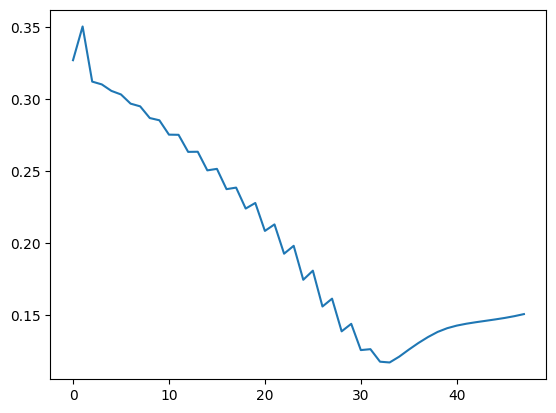

In [22]:
import matplotlib.pyplot as plt

plot_data = torch.mean(fourier_embeddings, dim=3)
difference_over_length = torch.mean(torch.abs(plot_data[:, :, 0] - torch.mean(plot_data[:, :, 1:])), dim=0)

plt.plot(difference_over_length.detach().numpy())

### Calculate using pyGSP

In [23]:
import numpy as np
from pygsp.graphs.fullconnected import FullConnected

G = FullConnected(N=nb_nodes)
G.compute_fourier_basis()

In [24]:
import matplotlib.pyplot as plt

test_embeddings = embeddings[1,  :, :].detach().numpy()
output  = G.gft(test_embeddings)

plot_data = np.mean(output, axis=1)
plt.plot(plot_data)

ValueError: First dimension should be the number of nodes G.N = 16, got (48, 16, 128).